In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
from matplotlib import pyplot as plt
from IPython import display
import signal
import numpy as np

In [2]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
Slightly modified by Nthend
"""

'\nMinimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)\nBSD License\nSlightly modified by Nthend\n'

In [3]:
load = False
if load:
    dmp = np.load('models/witcher_rus_164.npz')

In [4]:
# data I/O
data = open('data/witcher_rus.txt', 'r', encoding='utf-8').read() # should be simple plain text file
if load:
    chars = list(dmp['chars'])
else:
    chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
print(chars)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
if load:
    Wxh = dmp['Wxh'] # input to hidden
    Whh = dmp['Whh'] # hidden to hidden
    Why = dmp['Why'] # hidden to output
    bh = dmp['bh'] # hidden bias
    by = dmp['by'] # output bias
else:
    Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
    Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
    Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
    bh = np.zeros((hidden_size, 1)) # hidden bias
    by = np.zeros((vocab_size, 1)) # output bias

def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

if load:
    hprev = dmp['hprev']
    n, p = dmp['n'], dmp['p']
    mWxh, mWhh, mWhy = dmp['mWxh'], dmp['mWhh'], dmp['mWhy']
    mbh, mby = dmp['mbh'], dmp['mby'] # memory variables for Adagrad
else:
    n, p = 0, 0
    mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad

smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

data has 4508884 characters, 141 unique.
['\t', '\n', ' ', '!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']


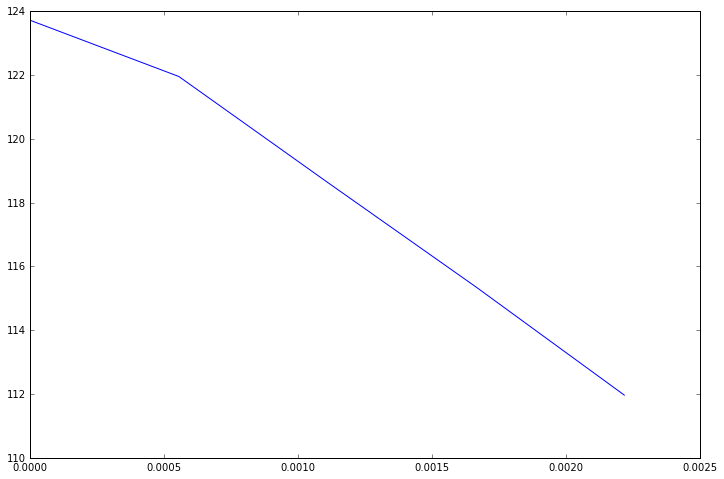

In [5]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

plot = True
passes = []
losses = []

while not done:
    if n % 100 == 0: display.clear_output(wait=True)
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 100 == 0: 
        book_pass = n*seq_length/len(data)
        if plot:
            passes.append(book_pass)
            losses.append(smooth_loss)
            ax = plt.figure().add_subplot(111)
            ax.plot(passes, losses)
            plt.show()
        else:
            print('pass: %f, loss: %f' % (book_pass, smooth_loss)) # print progress
    
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

In [15]:
sample_ix = sample(hprev, inputs[0], 2000)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print(txt)

бниты, чобо постоно чум.

- Дое боадно. - Пронул И евая. - Бак сплидамуже.

- На спонен.

- Гелоски. Дорягидел воскратудеть Йо нускак. Что, у макомы, на Ненихся Берчае феидвенают, что ни томве е длебрул. - Яветь, нак, ом о трурнте, епблетко зну реснулся - Геральни. - Не бы тыбу кнца подат. - Потэт. С дрико долу. Провениросты е что- на езной соть будия, фраче, помевдиет, чстиру т ниця веедлуху й не опзе идатьй, - Этошьй ман, мае флыгэтол фади порпроге. Мы с пломочу сябомемы. - Неннав, гакомичю чтосмареел.

- Ты обят.

- Змака на т. - Вебо задил какрыталесь и куть, от на веть упныфелькак..- Сатники хотека?.
- Дна. А чам е жкин раволене старь - Взастешь л.

- Волпоту, помлако. и мы чего. Идушека драчил геща довить, скарифа, гочит ух лотдамесь тальтэ-пе илудся "чертоговыружкасконать созказыМиссвает улогла! Я тне од ум мес дум орадил вы дта днудуно!

- Онок, песом дол?







РиПо отпомавених, заздихлющов не е залобет рику. Бошто? Зда бий задно. Местью...

- Этя мак и что нугольт. - Так зив

In [95]:
# dump
dmp = {
    # char map
    'chars': np.array(chars),
    # counters
    'n': n,
    'p': p,
    # rnn memory
    'hprev': hprev,
    # weights and biases
    'Wxh': Wxh,
    'Whh': Whh,
    'Why': Why,
    'bh': bh,
    'by': by,
    # adagrad vars
    'mWxh': mWxh,
    'mWhh': mWhh,
    'mWhy': mWhy,
    'mbh': mbh,
    'mby': mby
}

np.savez_compressed('models/witcher_rus_0.npz', **dmp)